# Initital Setup

### Import Required Python Packages

In [1]:
import sempy.fabric as fabric
import pyspark.pandas as ps 
from pyspark.pandas import set_option
from datetime import datetime

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 3, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.


### Install Required R packages

In [2]:
%%sparkr

pkgs <- c("ggthemes", "cowplot")
install.packages(pkgs)

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 5, Finished, Available, Finished)

Installing packages into ‘/nfs4/R/user-lib/application_1741426587105_0001’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/ggthemes_5.1.0.tar.gz'
Content type 'application/x-gzip' length 493992 bytes (482 KB)
downloaded 482 KB

trying URL 'https://cloud.r-project.org/src/contrib/cowplot_1.1.3.tar.gz'
Content type 'application/x-gzip' length 1350286 bytes (1.3 MB)
downloaded 1.3 MB

Loading required package: usethis
* installing *source* package ‘ggthemes’ ...
** package ‘ggthemes’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
Loading required package: usethis
** help
*** installing help indices
** building package indices
Loading required package: usethis
** testing if installed package can be loaded from temporary location
Loading required package: usethis
** testing if installed package can be loaded from final location
L

### Load Required R Packages

In [3]:
%%sparkr

library(tidyverse)
library(ggthemes)
library(lubridate)
library(scales)
library(cowplot)

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 6, Finished, Available, Finished)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ purrr     1.0.2
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ ggplot2   3.5.1     ✔ tidyr     1.3.1
✔ lubridate 1.9.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()       masks SparkR::arrange()
✖ dplyr::between()       masks SparkR::between()
✖ dplyr::coalesce()      masks SparkR::coalesce()
✖ dplyr::collect()       masks SparkR::collect(), sparklyr::collect()
✖ dplyr::contains()      masks tidyr::contains(), SparkR::contains()
✖ dplyr::count()         masks SparkR::count()
✖ dplyr::cume_dist()     masks SparkR::cume_dist()
✖ dplyr::dense_rank()    masks SparkR::dense_rank()
✖ dplyr::desc()          masks SparkR::desc()
✖ dplyr::distinct()      masks SparkR::distinct(), sparklyr::distinct()
✖ dplyr::explain()       masks SparkR::explain()
✖ dplyr::expr()          masks ggplot2::expr(), SparkR::expr()
✖ tidyr::extract()       mas

### Create a **spark_connect()** object

In [4]:
%%sparkr

spark_version <- sparkR.version()
config <- spark_config()
sc <- spark_connect(master = "yarn", version = spark_version, spark_home = "/opt/spark", method = "synapse", config = config)


StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 7, Finished, Available, Finished)

# Create Demand Forecast Chart

### Dynamically create the required DAX Query

In [5]:
store = 'Store9'
product = 'Product37'

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 8, Finished, Available, Finished)

In [6]:

daxQuery = f'''EVALUATE
	SUMMARIZECOLUMNS(
		store_information[StoreName],
		product_information[ProductName],
		dateinformation[DateKey],
		TREATAS({{"{store}"}}, store_information[StoreName]),
		TREATAS({{"{product}"}}, product_information[ProductName]),
		"TotalSales", [Total Sales],
		"PredictedSales", [PredictedSales],
		"PredictedSalesLower", [PredictedSalesLower],
		"PredictedSalesUpper", [PredictedSalesUpper],
		"Trend", [Total Trend],
		"TrendLower", [TrendLower],
		"TrendUpper", [TrendUpper],
		"WeeklySeasonality", [WeeklySeasonality],
		"YearlySeasonality", [YearlySeasonality]					
	)
'''

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 9, Finished, Available, Finished)

### Create a R data frame based on the results of the DAX query

Populate a fabric data frame with the results of the DAX query and convert the data frame to a temporary view that can be accessed by SparkR

In [7]:
semantic_model = "demandforecast"
fdfDemandForecastRawData = fabric.evaluate_dax(semantic_model, daxQuery)
sdfDemandForecastRawData = spark.createDataFrame(fdfDemandForecastRawData)
sdfDemandForecastRawData.createOrReplaceTempView("vwDemandForecastRawData")

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 10, Finished, Available, Finished)

Create a Sparklr data frame based on the temporary view then converts the data frame into a regular R data frame so that it can be used by **ggplot**

In [8]:
%%sparkr

slrdfDemandForecastRawData = tbl(sc, "vwDemandForecastRawData")
rdfDemandForecastRawData = collect(slrdfDemandForecastRawData)

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 11, Finished, Available, Finished)

### Make required updates to the R data frame

In [9]:
%%sparkr

rdfDemandForecastRawData <-
     rdfDemandForecastRawData %>%
        rename(
            "StoreName" = "store_information[StoreName]",     
            "ProductName" = "product_information[ProductName]",
            "DateKey" = "dateinformation[DateKey]", 
            "Sales" = "[TotalSales]",        
            "Predicted_Sales" = "[PredictedSales]", 
            "Predicted_Sales_Lower" = "[PredictedSalesLower]",
            "Predicted_Sales_Upper" = "[PredictedSalesUpper]",
            "Trend" = "[Trend]",
            "Trend_Lower" = "[TrendLower]",
            "Trend_Upper" = "[TrendUpper]",
            "Weekly_Seasonality" = "[WeeklySeasonality]",
            "Yearly_Seasonality" = "[YearlySeasonality]"
        )

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 12, Finished, Available, Finished)

### Build the R Visual

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 13, Finished, Available, Finished)

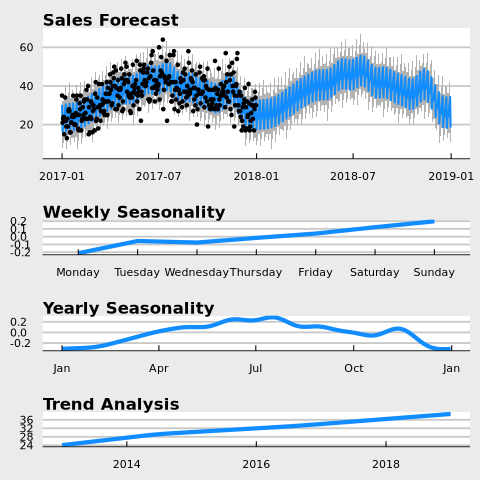

In [10]:
%%sparkr

dataset <- rdfDemandForecastRawData

ForecastEndDate <- 20181231

max_data_date <- ymd(max(dataset$Date[!is.na(dataset$Sales)]))
    
    initial_data <-
      dataset %>%
      select(DateKey, Sales, Predicted_Sales, Predicted_Sales_Lower, Predicted_Sales_Upper, 
             Trend, Trend_Lower, Trend_Upper, Weekly_Seasonality, Yearly_Seasonality) %>%
      mutate(Date = ymd(DateKey))
    
    sales_forecast_date <- 
      initial_data %>%
      filter(DateKey >= 20170101 & DateKey <= ForecastEndDate)

    yearchart_data <-
      initial_data %>%
      select(Date, Sales, Predicted_Sales, Predicted_Sales_Lower, Predicted_Sales_Upper, 
             Trend, Trend_Lower, Trend_Upper, Yearly_Seasonality)
    
    first_monday <- 
      min(initial_data$Date) + 
      days(8-wday(min(initial_data$Date), week_start = getOption("lubridate.week.start", 1)))
    
    first_sunday <- first_monday + days(6)
    
    weekchart_data <-
      initial_data %>%
      filter(Date >= first_monday & Date <= first_sunday) %>%
      mutate(Date, weekday = as.character(weekdays(Date, abbreviate = FALSE)), Weekly_Seasonality, group = "a") %>%
      select(Date, weekday, Weekly_Seasonality, group)
    
    p_forecast <- ggplot(data = sales_forecast_date, mapping = aes(x = Date, y=Predicted_Sales)) +
      geom_ribbon(mapping = aes(ymin = Predicted_Sales_Lower, ymax = Predicted_Sales_Upper), fill = "grey70") +
      geom_line(color = '#118DFF', size = 1) +  
      geom_point(mapping = aes(y=Sales), na.rm=TRUE) +
      geom_vline(xintercept = max_data_date, linetype = "dashed", color = "black", size = 1) +
      theme_economist_white() +
      labs(title = "Sales Forecast", x=NULL, y=NULL)
    
    p_week_seasonality <- ggplot(data = weekchart_data, aes(x = fct_reorder(weekday, Date, .desc = FALSE), y = Weekly_Seasonality, group = group)) +
      geom_line(size = 2 ,color = "#118DFF") +
      labs(title = "Weekly Seasonality", x=NULL, y=NULL) +
      theme_economist_white()
    
    p_year_seasonality <- ggplot(data = filter(yearchart_data, year(Date) == 2016), aes(x = Date, y = Yearly_Seasonality)) +
      geom_line(color = "#118DFF", size=2) +
      scale_x_date(labels = date_format("%b")) +
      labs(title = "Yearly Seasonality", x=NULL, y=NULL) +
      theme_economist_white()
    
    p_year_trend <- ggplot(data = yearchart_data, aes(x = Date, y = Trend, ymin = Trend_Lower, ymax = Trend_Upper)) +
      geom_ribbon(fill = "light grey") +
      geom_line(color = "#118DFF", size=2) +  
      labs(title = "Trend Analysis", x=NULL, y=NULL) +
      theme_economist_white()
    
    p <- plot_grid(
      p_forecast, p_week_seasonality, p_year_seasonality, p_year_trend, 
      align = "v", 
      nrow = 4, 
      rel_heights = c(2/5, 1/5, 1/5, 1/5)
    )

    p

In [11]:
%%sparkr

ggsave("/lakehouse/default/Files/Images/plot.png", plot = p, width = 12, height = 10)

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 14, Finished, Available, Finished)

### R Resources

# Map Visual using R

### Load Data

In [12]:
sdfMapData = spark.read.format("csv").option("header","true").load("Files/MapData.csv")

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 15, Finished, Available, Finished)

In [13]:
sdfFultonCounty = sdfMapData.filter("State == 'GA' and County == 'fulton'")
display(sdfFultonCounty)

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 16, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 8b85141a-1fdc-4905-b5db-9c0c63151e40)

### Apply State Filter

In [14]:
State = 'GA'
sdfRawPlotData = sdfMapData.filter(f"State == '{State}'")
sdfRawPlotData.createOrReplaceTempView("vwrawplotdata")

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 17, Finished, Available, Finished)

### Converts the temporary view to a regular R data frame

In [15]:
%%sparkr

slrdfRawPlotData <- tbl(sc, "vwrawplotdata")
rdfRawPlotData <- collect(slrdfRawPlotData)

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 18, Finished, Available, Finished)

### Set some important variables

In [16]:
%%sparkr

state <- unique(rdfRawPlotData$State)

chartTitle <- paste0(state, "'s County Population Analysis")
subTitle <- "(the darker shades the higher the population)"

rdfPlotData <-
  rdfRawPlotData %>%
  filter(State == state) %>%
  mutate(
    lat = parse_number(lat),
    long = parse_number(long),
    quintile = factor(ntile(`Total Population`, 5))
  )

# http://www.stat.columbia.edu/~tzheng/files/Rcolor.pdf
quintileColors <-
  c(
    "1" = "dodgerblue",
    "2" = "dodgerblue1",
    "3" = "dodgerblue2",
    "4" = "dodgerblue3",
    "5" = "dodgerblue4"
  )

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 19, Finished, Available, Finished)

### Create the map visual using ggplot

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 20, Finished, Available, Finished)

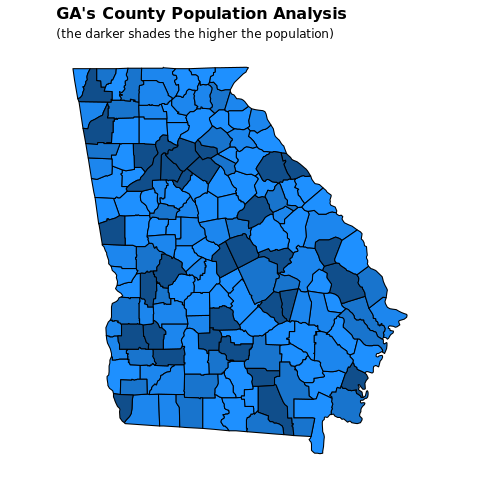

In [17]:
%%sparkr

p <- ggplot(rdfPlotData, aes(long, lat, group = County, fill = quintile)) +
  geom_polygon(show.legend = FALSE, color = "black") +
  scale_x_continuous(name = NULL, labels = NULL, breaks = NULL) +
  scale_y_continuous(name = NULL, labels = NULL, breaks = NULL) +
  scale_fill_manual(values = quintileColors) +
  coord_quickmap() +
  ggtitle(chartTitle, subtitle = subTitle) +
  theme_map()

p

# Create Star Schema from a Flat File

**Power BI** handles the reporting tasks in **Microsoft Fabric**. To get the most for Power BI, it is very important to make sure your data model is in a **star schema** format. **Power BI** preferes the **star schema** data model format because it:

- makes it easier for report developers to navigate the data model when desginging reports
- makes it easier for BI developers to create **DAX measures**
- reduces data redundancy and model size
- improves performance

The level of complexity it takes to convert your data into a **star schema** format depends on the source data and the type of dimension tables you want to include in your model. Going from raw data to a **star schema** data model often involves processing your data in several stages with the final stage being a **star schema** data model. The most modern approach of this type of archeticture is the **Medallion Architecture**. THe **Medallion Architecture** stores data in 3 different layers based on the processing state it is in. Those layers are the **bronze layer**, **silver layer**, and **gold layer**. This arhitecture was invtented by our friends at **Databricks** and you can find more about it here: https://www.databricks.com/glossary/medallion-architecture. 

We will illustrate a relatively simple example of the **Medallion Architecture** in which we go from flat files to **star schema** or, in other words, from the **bronze layer** to **gold layer**. This method is simple enough to describe in a relatively short **Fabric Notebook** but complex engough to illustrate some of **Microsoft Fabric's** data engineering capabilities.

The steps required to go from **flat files** to **star schema data model** are thoroughly covered in this notebook. Annotations are included in the form of **markdown cells** to describe the code used to do the conversion. On a high-level, the notebook shows how to:

- read in disparate flat files stored in the **bronze layer** into on data frame
- prep the data frame with information needed to build a **star schema** data model
- extract the dimension tables and fact table from the enhanced data frame created in the previous step
- dynamically build a **date** table complete with important date attributes needed for time intelligence reporting
- save the resulting dimension tables and fact table in the **gold layer** located in your **Microsoft Fabric** lakehouse in **delta format**


### Import the flat file into a spark data frame and convert it to a temporary view

In [18]:
sdfSalesData = spark.read.format("csv").option("header","true").load("Files/SalesData.csv")
sdfSalesData.createOrReplaceTempView("vwsalesdata")

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 21, Finished, Available, Finished)

### Create Keys

Uses the **xxhash64()** function to create a unique integer value of the combinations for the customers and products

In [19]:
%%sql

SELECT
     xxhash64(concat_ws('|', FirstName, LastName, Gender, Education)) AS customer_hashkey 
    ,FirstName
    ,LastName
    ,Gender
    ,Education
    ,xxhash64(concat_ws('|', ProductName, ProductSubcategoryName, SizeRange)) AS customer_hashkey
    ,ProductName
    ,ProductSubcategoryName
    ,SizeRange
    ,OrderDate
    ,DueDate
    ,ShipDate
    ,OrderQuantity
    ,TotalSales
    ,TotalTaxAmount
FROM vwsalesdata 
ORDER BY FirstName, LastName, Gender, Education
limit 6


StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 22, Finished, Available, Finished)

<Spark SQL result set with 6 rows and 15 fields>

Uses the **DENSE_RANK()** window function to replace the much bigger hash keys. The results are saved in the **vwstarschemasource** temporary view and will be the source for the dimension and fact tables.

In [20]:
%%sql
CREATE OR REPLACE TEMP VIEW vwstarschemasource
AS

WITH cteStarSchemaSource AS (
    SELECT
        xxhash64(concat_ws('|', sd.FirstName, sd.LastName, sd.Gender, sd.Education)) AS customer_hashkey 
        ,sd.FirstName
        ,sd.LastName
        ,sd.Gender
        ,sd.Education
        ,xxhash64(concat_ws('|', sd.ProductName, sd.ProductSubcategoryName, sd.SizeRange)) AS product_hashkey
        ,sd.ProductName
        ,sd.ProductSubcategoryName
        ,sd.SizeRange
        ,sd.OrderDate
        ,sd.DueDate
        ,sd.ShipDate        
        ,sd.OrderQuantity
        ,sd.TotalSales
        ,sd.TotalTaxAmount
    FROM vwsalesdata AS sd
)

SELECT
     customer_hashkey
    ,DENSE_RANK() OVER(ORDER BY customer_hashkey) AS customer_key
    ,FirstName
    ,LastName
    ,Gender
    ,Education
    ,product_hashkey
    ,DENSE_RANK() OVER(ORDER BY product_hashkey) AS product_key
    ,ProductName
    ,ProductSubcategoryName
    ,SizeRange
    ,OrderDate
    ,DueDate
    ,ShipDate    
    ,OrderQuantity
    ,TotalSales
    ,TotalTaxAmount
FROM cteStarSchemaSource


StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 23, Finished, Available, Finished)

<Spark SQL result set with 0 rows and 0 fields>

### Create spark tables to warehouse the fact and dimension tables

Creates the customer dimension table

In [21]:
strSQL = '''
SELECT DISTINCT
     customer_hashkey
    ,customer_key
    ,FirstName
    ,LastName
    ,Gender
    ,Education
FROM vwstarschemasource
'''
spark.sql(strSQL).write.format("delta").mode("overwrite").option("overwriteSchema","true").saveAsTable("customer_info")


StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 24, Finished, Available, Finished)

Creates the product dimension table

In [22]:
strSQL = '''
SELECT DISTINCT
     product_key
    ,customer_hashkey
    ,ProductName
    ,ProductSubcategoryName
    ,SizeRange
FROM vwstarschemasource
'''

spark.sql(strSQL).write.format("delta").mode("overwrite").option("overwriteSchema","true").saveAsTable("product_info")


StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 25, Finished, Available, Finished)

Creates the fact table

In [23]:
strSQL = '''
SELECT
     product_key
    ,customer_key
    ,OrderDate
    ,DueDate
    ,ShipDate    
    ,OrderQuantity
    ,TotalSales
    ,TotalTaxAmount
FROM vwstarschemasource
'''

spark.sql(strSQL).write.format("delta").mode("overwrite").option("overwriteSchema","true").saveAsTable("Sales")

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 26, Finished, Available, Finished)

In [24]:
%%sql

SELECT * FROM customer_info limit 5

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 27, Finished, Available, Finished)

<Spark SQL result set with 5 rows and 6 fields>

In [25]:
%%sql

SELECT * FROM product_info limit 5

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 28, Finished, Available, Finished)

<Spark SQL result set with 5 rows and 5 fields>

In [26]:
%%sql

SELECT * FROM sales limit 5

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 29, Finished, Available, Finished)

<Spark SQL result set with 5 rows and 8 fields>

# Dynamically creates a ***Date*** table for our ***Star Schema*** data model

### Setup

One of the most important and most common dimension table in a ***Star Schema*** data model is the ***Date Dimension*** table. The ***Date Dimension*** table in a star schema data model enables you to perform time intelligence calculation like **YoY**, **MoM**, and **YTD** calculations to in a relatively easy manner. 

Below, is reusable code that you can use to dynamically generate a **Date Table** complete with important date attributes based on your date range requirements. What follows are the code cells that dynamically generates a date table along with **markdown cells** that describes what the code cells are doing.

The code cell below assigns the start and end date that you want for your ***Date*** table to the **start_date** and **end_date** variable respectively. Make sure to use **yyyy-MM-dd** format.

In [27]:
start_date = "2011-01-01"
end_date = "2011-12-31"

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 30, Finished, Available, Finished)

The **start_date** and **end_date** variable stores what appears to be a date value but the values are actually strings. We need to convert those values to a date format so that we can perform date operations against them. The **datetime.strptime()** method enables you to parse the string representation of the dates to a date format. 

Let's explain how the date is parsed using the following code snippet: `start_date_parsed = datetime.strptime(start_date, '%Y-%m-%d')`. The **datetime.strptime()** takes the string date value as the first argument and the date format string as your second argument. The date format string tells the **datetime.strptime()** function what format your string date value is in. That information is used by the **datetime.strptime()** how to parse the string. Here is a link to a site that shows some of the format strings available to you: https://www.programiz.com/python-programming/datetime/strptime. 

In [28]:
start_date_parsed = datetime.strptime(start_date, '%Y-%m-%d')
end_date_parsed = datetime.strptime(end_date, '%Y-%m-%d')

num_days = (end_date_parsed-start_date_parsed).days + 1

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 31, Finished, Available, Finished)

The code snippet in the second cole cell below dynamically builds a ***Date*** table with common date attributes that has a begin date equal to the **start_date** variable and an end date equal to the **end_date** variable we createdly preveiously. Notice that the code heavily relies on the **date_format()** function. The **date_format()** functions converts the date into a string in a format based on the format string we passed to it. The **date_format()** uses different format strings than **datetime.strptime()**. Here is a link to a site that covers the format stings available to the **date_format()** function: https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html. 

### Introducing **A Table of Numbers (ATON)**

The basis of the **Date** table uses a SQL hack known as a ***A Table of Numbers (ATON)***. **ATON** enables you to efficently perform certain tasks in SQL that would otherwise be hard or impossible without it. We will be using **ATTON** to help us build our date table but note that **ATON** has many more uses. 

The code snippet below shows how to use a recursive ***Common Table Expressions (CTEs)*** to dynamically generate a list of numbers that goes from 1 to 65,536. Using **ATON** generated this way enables you to dynamically build a **Date** table without having to rely on an existing table or view in your database.

In [29]:
%%sql 

WITH
  Pass0 as (select 1 as C union all select 1),
  Pass1 as (select 1 as C from Pass0 as A, Pass0 as B),
  Pass2 as (select 1 as C from Pass1 as A, Pass1 as B),
  Pass3 as (select 1 as C from Pass2 as A, Pass2 as B),
  Pass4 as (select 1 as C from Pass3 as A, Pass3 as B),
  ATON as (select row_number() over(order by C) as ROW_NUM from Pass4)

SELECT * FROM ATON LIMIT 5

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 32, Finished, Available, Finished)

<Spark SQL result set with 5 rows and 1 fields>

### Construct a dynamic SQL statement and use it to source the date dimension table

Below is the complete SQL script to create the **Date** table. The code cell below is:

- **Leveraging** ***ATON*** **to create a date table**: ***ATON*** has many uses uses in SQL development and this notebook will illustrate how to use it to help generate a date table.
- **Using f format string**: Constructing your string by prefacing it with a **f** enables you easily make certain parts of your string dynamic via the use of **{}** in your string that serves as places-holders for the dynamic text you want to include in your string. 
- **Using functions to create date attributes**: **date_format()** and date functions such as **year()**, **month()**, and **dayofweek** are used to create the date functions.
- **Using** ***spark.sqk()*** **was used**: Also note that we are dyncamically building a SQL statement and using the **spark.sql()** function to run the query in **SparkSQL** and return the output of the query to a data frame.

In [30]:
strSQL = f"""
WITH
  Pass0 as (select 1 as C union all select 1),
  Pass1 as (select 1 as C from Pass0 as A, Pass0 as B),
  Pass2 as (select 1 as C from Pass1 as A, Pass1 as B),
  Pass3 as (select 1 as C from Pass2 as A, Pass2 as B),
  Pass4 as (select 1 as C from Pass3 as A, Pass3 as B),
  ATON as (select row_number() over(order by C) as ROW_NUM from Pass4),

  BaseDateTable AS (
    SELECT
        DATEADD(DAY, t.ROW_NUM - 1, '{start_date}') AS `Date`
        ,YEAR(DATEADD(DAY, t.ROW_NUM - 1, '{start_date}')) AS `Year`
        ,date_format(DATEADD(DAY, t.ROW_NUM - 1, '{start_date}'), 'MMM yyyy') AS MonthYr
        ,date_format(DATEADD(DAY, t.ROW_NUM - 1, '{start_date}'), 'MMM') AS `Month`
        ,DATEADD(
                DAY,
                CASE dayofweek(DATEADD(DAY, t.ROW_NUM - 1, '{start_date}'))
                    WHEN 1 THEN -6
                    WHEN 2 THEN 0
                    WHEN 3 THEN -1
                    WHEN 4 THEN -2
                    WHEN 5 THEN -3
                    WHEN 6 THEN -4
                    WHEN 7 THEN -5
                END,
                DATEADD(DAY, t.ROW_NUM - 1, '{start_date}')
            ) AS Week
        ,date_format(DATEADD(DAY, t.ROW_NUM - 1, '{start_date}'), 'E') AS WeekdayName
        ,date_format(DATEADD(DAY, t.ROW_NUM - 1, '{start_date}'), 'yyyyMM') AS MonthYrKey
        ,month(DATEADD(DAY, t.ROW_NUM - 1, '{start_date}')) AS MonthKey
        ,CASE dayofweek(DATEADD(DAY, t.ROW_NUM - 1, '{start_date}'))
            WHEN 1 THEN 7
            ELSE dayofweek(DATEADD(DAY, t.ROW_NUM - 1, '{start_date}'))-1 
        END AS WeekdayKey
    FROM ATON t
    WHERE t.ROW_NUM <={num_days}
)

SELECT * 
FROM BaseDateTable
"""

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 33, Finished, Available, Finished)

### Save the results to a spark table

Writes the result of the query to a spark table

In [31]:
spark.sql(strSQL).write.format("delta").mode("overwrite").option("overwriteSchema","true").saveAsTable("DateInfo")

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 34, Finished, Available, Finished)

In [32]:
%%sql

SELECT * FROM dateinfo ORDER BY Date limit 10

StatementMeta(, 8fc50215-28e6-4507-a215-07105049b427, 35, Finished, Available, Finished)

<Spark SQL result set with 10 rows and 9 fields>